# **-------------------- Linear kernel vs Poly kernel ------------------------------**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to visualize decision boundaries
def plot_decision_boundary(X, y, clf, title, ax):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

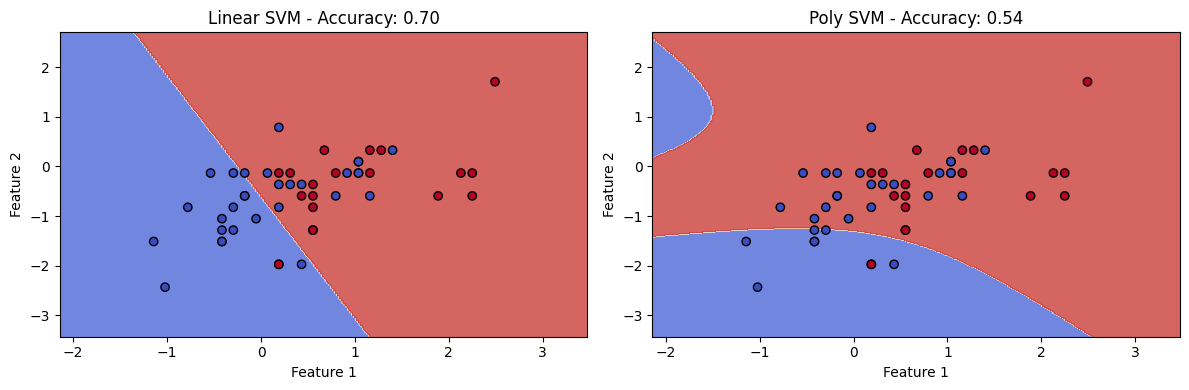

In [ ]:
scaler = StandardScaler()
iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)
y = iris.target
X = X[y != 0, :2]
y = y[y != 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Linear Kernel SVM
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
linear_accuracy = linear_svm.score(X_test, y_test)

# Polynomial Kernel SVM
poly_svm = SVC(kernel='poly', degree=3)
poly_svm.fit(X_train, y_train)
poly_accuracy = poly_svm.score(X_test, y_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Visualize decision boundaries
plot_decision_boundary(X_test, y_test, linear_svm, f'Linear SVM - Accuracy: {linear_accuracy:.2f}', axes[0])
plot_decision_boundary(X_test, y_test, poly_svm, f'Poly SVM - Accuracy: {poly_accuracy:.2f}', axes[1])

# Adjust layout and show plots
plt.tight_layout()
plt.show()


# **------------------------------------ Classification de visages ---------------------------**

In [ ]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# Load the Labeled Faces in the Wild (LFW) dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract information about the dataset
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names1 = lfw_people.target_names
selected_classes = ['Tony Blair', 'Colin Powell']

# Filter target_names to include only the selected classes
target_names = [name for name in target_names1 if name in selected_classes]

# Filter the dataset to include only Tony Blair and Colin Powell
selected_indices = [i for i in range(n_samples) if target_names1[y[i]] in selected_classes]

# Filter y to include only the labels corresponding to selected classes
y_selected = y[selected_indices]

# Use the filtered y to create the selected_indices
selected_indices = [i for i in range(n_samples) if y[i] in y_selected]

X_selected = X[selected_indices]
y_selected = y[selected_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

print("Selected dataset size: %s"%target_names)
print("n_classes: %d" % len(selected_classes))
print("n_train : %d"%len(X_train))
print("n_test : %d"%len(X_test))

Selected dataset size: ['Colin Powell', 'Tony Blair']
n_classes: 2
n_train : 285
n_test : 95


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 285 faces
done in 0.244s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s


In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.919s
Best estimator found by grid search:
SVC(C=7636.4269620824325, class_weight='balanced', gamma=0.0023008728837763275)


Predicting people's names on the test set
done in 0.010s
              precision    recall  f1-score   support

Colin Powell       0.98      0.92      0.95        63
  Tony Blair       0.86      0.97      0.91        32

    accuracy                           0.94        95
   macro avg       0.92      0.94      0.93        95
weighted avg       0.94      0.94      0.94        95



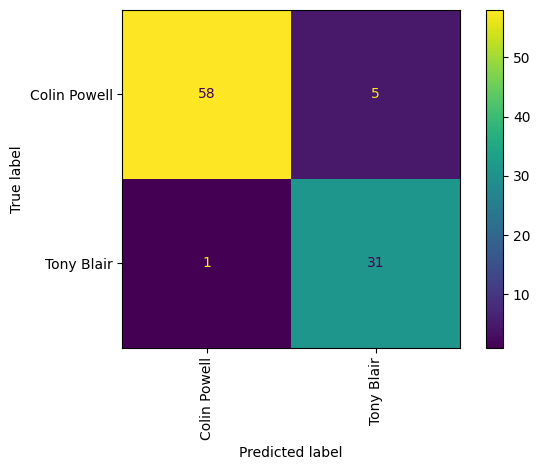

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

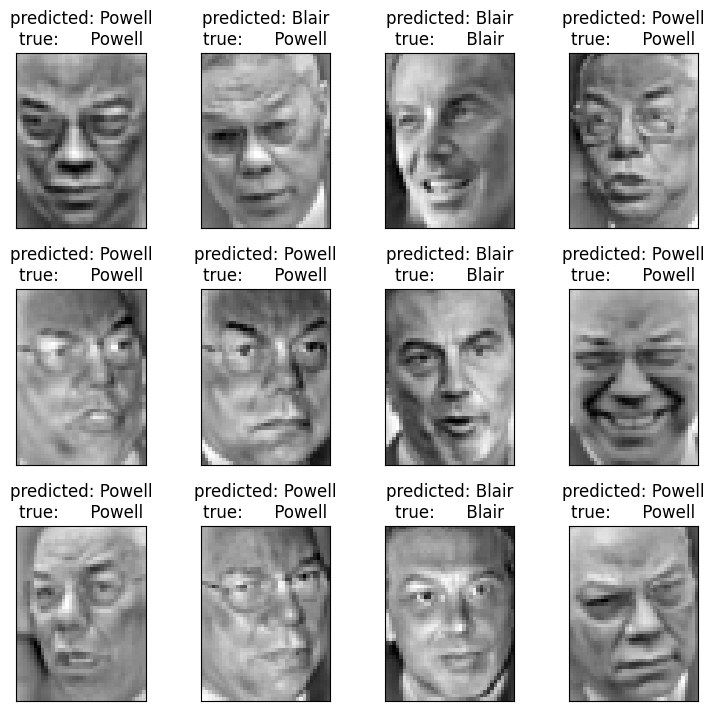

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [
    title(y_pred, y_test, target_names1, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)


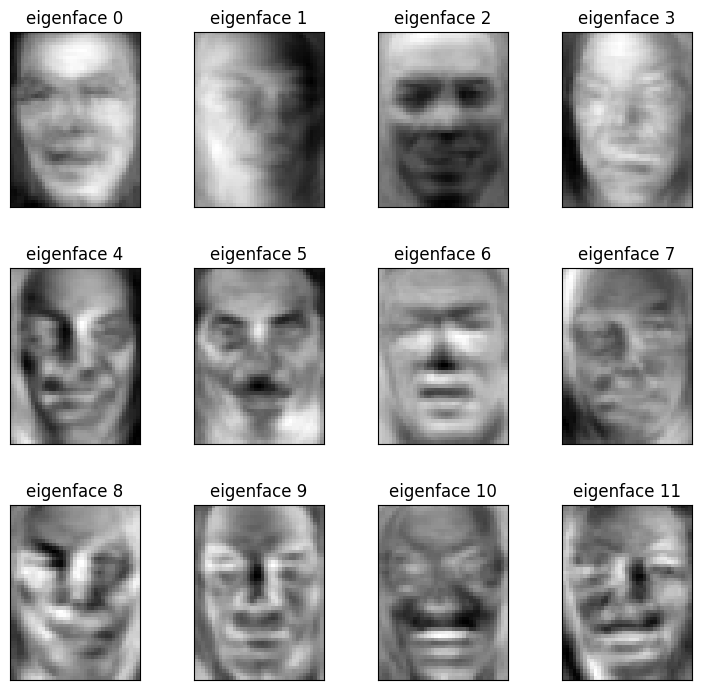

In [ ]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# **---------------------------- Influence du paramètre C ------------------------**

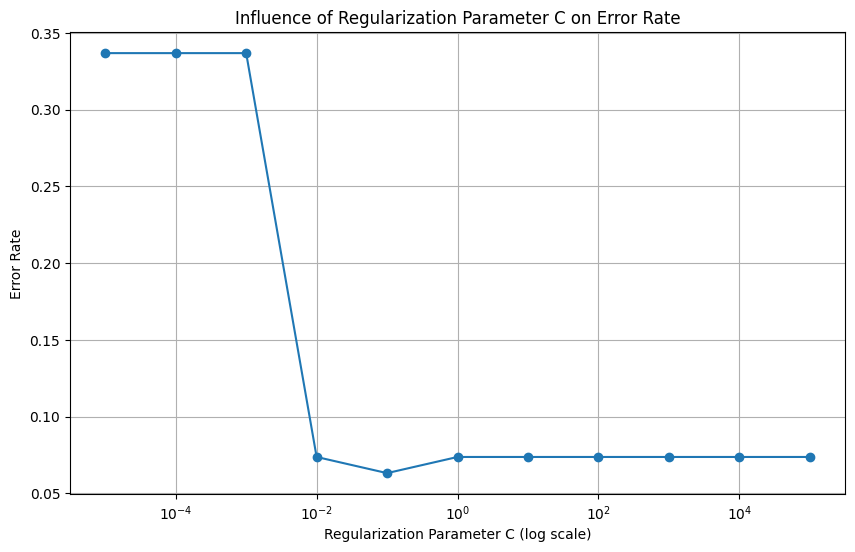

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from time import time

# Load the Labeled Faces in the Wild (LFW) dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract information about the dataset
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names1 = lfw_people.target_names
selected_classes = ['Tony Blair', 'Colin Powell']

# Filter target_names to include only the selected classes
target_names = [name for name in target_names1 if name in selected_classes]

# Filter the dataset to include only Tony Blair and Colin Powell
selected_indices = [i for i in range(n_samples) if target_names1[y[i]] in selected_classes]

# Filter y to include only the labels corresponding to selected classes
y_selected = y[selected_indices]

# Use the filtered y to create the selected_indices
selected_indices = [i for i in range(n_samples) if y[i] in y_selected]

X_selected = X[selected_indices]
y_selected = y[selected_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

# Normalize the data (features are already centered and scaled)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
n_components = 150  # Number of principal components
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Range of values for the regularization parameter C
C_values = np.logspace(-5, 5, num=11)

# Lists to store results
error_rates = []

# Iterate over different values of C
for C_val in C_values:
    # Train an SVM classifier with the current C value
    clf = SVC(kernel='linear', C=C_val)
    clf.fit(X_train_pca, y_train)

    # Predict labels on the test set
    y_pred = clf.predict(X_test_pca)

    # Calculate error rate
    error_rate = 1 - clf.score(X_test_pca, y_test)
    error_rates.append(error_rate)

# Plot the influence of the regularization parameter C on the error rate
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, error_rates, marker='o')
plt.title('Influence of Regularization Parameter C on Error Rate')
plt.xlabel('Regularization Parameter C (log scale)')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# **---------------------------- Variables de nuisances ------------------------**

Predicting people's names on the test set
              precision    recall  f1-score   support

Colin Powell       0.96      0.86      0.91        63
  Tony Blair       0.77      0.94      0.85        32

    accuracy                           0.88        95
   macro avg       0.87      0.90      0.88        95
weighted avg       0.90      0.88      0.89        95



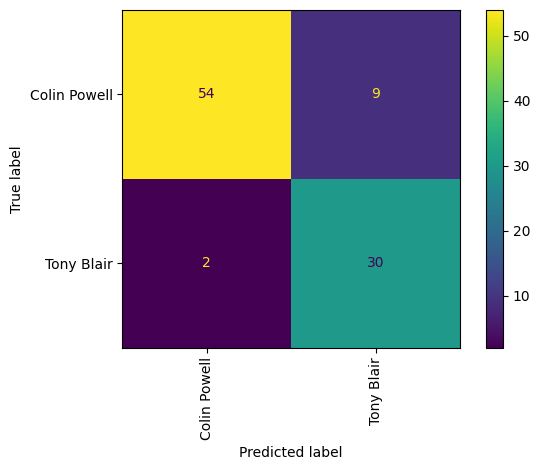

done in 0.478s


In [ ]:
# Load the Labeled Faces in the Wild (LFW) dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract information about the dataset
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names1 = lfw_people.target_names
selected_classes = ['Tony Blair', 'Colin Powell']

# Filter target_names to include only the selected classes
target_names = [name for name in target_names1 if name in selected_classes]

# Filter the dataset to include only Tony Blair and Colin Powell
selected_indices = [i for i in range(n_samples) if target_names1[y[i]] in selected_classes]

# Filter y to include only the labels corresponding to selected classes
y_selected = y[selected_indices]

# Use the filtered y to create the selected_indices
selected_indices = [i for i in range(n_samples) if y[i] in y_selected]

X_selected = X[selected_indices]
y_selected = y[selected_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

# Add nuisance variables (randomly generated normal variables)
num_nuisance_variables = 300
nuisance_variables = np.random.normal(0, 1, size=(X_train.shape[0], num_nuisance_variables))
X_train_with_nuisance = np.hstack((X_train, nuisance_variables))

nuisance_variables_test = np.random.normal(0, 1, size=(X_test.shape[0], num_nuisance_variables))
X_test_with_nuisance = np.hstack((X_test, nuisance_variables_test))

# Normalize the data (features are already centered and scaled)
scaler = StandardScaler()
X_train_with_nuisance = scaler.fit_transform(X_train_with_nuisance)
X_test_with_nuisance = scaler.transform(X_test_with_nuisance)

# Apply PCA
n_components = 150  # Number of principal components
pca = PCA(n_components=n_components, whiten=True).fit(X_train_with_nuisance)
X_train_pca = pca.transform(X_train_with_nuisance)
X_test_pca = pca.transform(X_test_with_nuisance)

# Train an SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train_pca, y_train)

# Predict labels on the test set
y_pred = clf.predict(X_test_pca)

# Evaluate and visualize the results
print("Predicting people's names on the test set")
t0 = time()
print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()
print("done in %0.3fs" % (time() - t0))

# **------------------------------- Primal vs Dual -------------------------------**

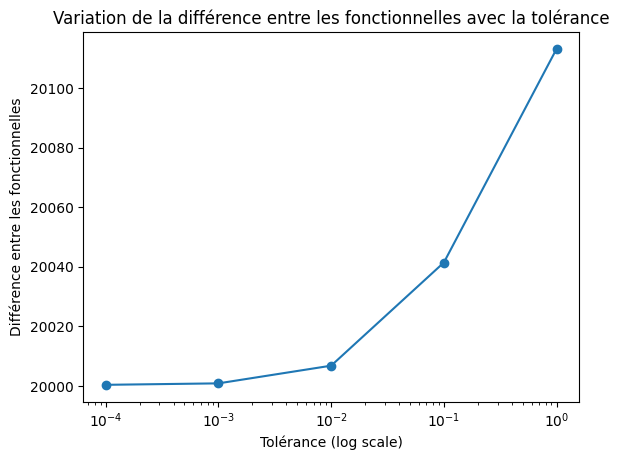

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# Fonction pour calculer les fonctionnelles primales et duales
def calculate_functionals(X, y, tol):
    clf = svm.SVC(kernel="linear", C=1000, tol=tol)
    clf.fit(X, y)
    # Calcul des fonctionnelles primales
    primal_functional = 0.5 * np.dot(clf.coef_, clf.coef_.T) + clf.C * np.sum(np.maximum(0, 1 - y * clf.decision_function(X)))
    # Calcul des fonctionnelles duales
    dual_functional = np.sum(clf.dual_coef_ * clf.dual_coef_) / 2
    return primal_functional, dual_functional

# Génération de données
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# Valeurs de tolérance à tester
tolerances = np.logspace(-4, 0, 5)

# Calcul des différences entre les fonctionnelles
differences = np.zeros_like(tolerances)
for i, tol in enumerate(tolerances):
    primal, dual = calculate_functionals(X, y, tol)
    differences[i] = np.abs(primal - dual)

# Affichage des résultats
plt.plot(tolerances, differences, marker='o')
plt.xscale('log')
plt.xlabel('Tolérance (log scale)')
plt.ylabel('Différence entre les fonctionnelles')
plt.title('Variation de la différence entre les fonctionnelles avec la tolérance')
plt.show()